In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

# Engenharia de Features

In [2]:
def load_data(dataset):
    path = f'../data/olist_{dataset}_dataset.parquet'
    return pd.read_parquet(path=path)

In [3]:
customers = load_data('customers')
geolocation = load_data('geolocation')
order_items = load_data('order_items')
order_payments = load_data('order_payments')
order_reviews = load_data('order_reviews')
orders = load_data('orders')
products = load_data('products')
sellers = load_data('sellers')

In [4]:
#união de clientes e pedidos
customers_orders = pd.merge(customers, orders, on='customer_id', how='inner')

## Clientes e pedidos

In [5]:
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [6]:
customers_orders.count()

customer_id                      99441
customer_unique_id               99441
customer_zip_code_prefix         99441
customer_city                    99441
customer_state                   99441
order_id                         99441
order_status                     99441
order_purchase_timestamp         99441
order_approved_at                99281
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
order_estimated_delivery_date    99441
dtype: int64

## Duplicatas

In [7]:
print(f'{customers_orders.duplicated().sum()} registros duplicados')

0 registros duplicados


## Nulos

In [8]:
customers_orders.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [9]:
customers_orders.dropna(inplace=True)

In [10]:
total_clientes_mulitplas_compras = customers_orders['customer_unique_id'].duplicated().sum()
print(f'{total_clientes_mulitplas_compras} Clientes compraram mais de uma vez')

3119 Clientes compraram mais de uma vez


## Distribuição - Order Status

In [11]:
customers_orders['order_status'].value_counts()

order_status
delivered    96455
canceled         6
Name: count, dtype: int64

order_status
canceled         6
delivered    93336
Name: customer_unique_id, dtype: int64


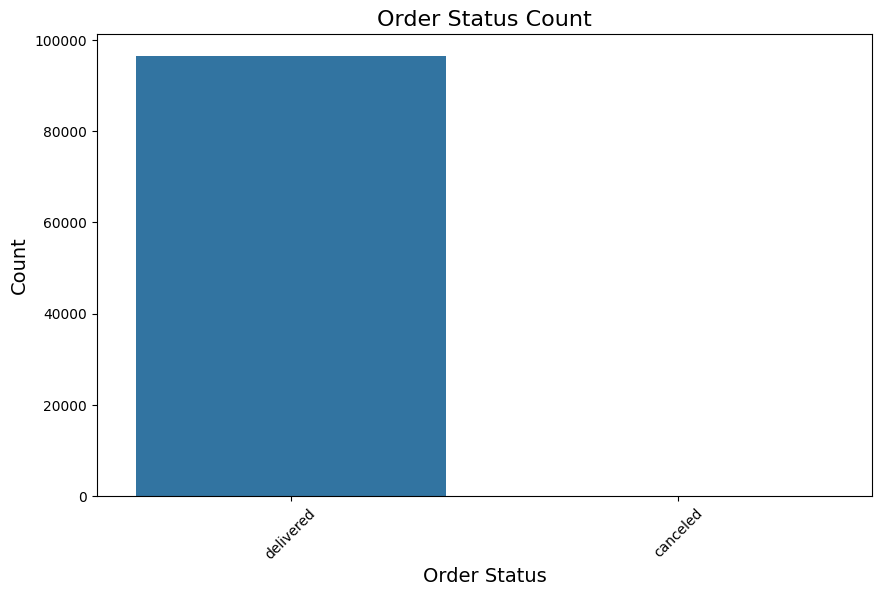

In [12]:
print(customers_orders.groupby('order_status')['customer_unique_id'].nunique())

plt.figure(figsize=(10,6))
sns.countplot(x='order_status', data=customers_orders)
plt.title('Order Status Count', fontsize=16)
plt.xlabel('Order Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Certificando tipagem de dados - DATAS

In [13]:
customers_orders['order_purchase_timestamp'] = pd.to_datetime(customers_orders['order_purchase_timestamp'])
customers_orders['order_approved_at'] = pd.to_datetime(customers_orders['order_approved_at'])
customers_orders['order_delivered_carrier_date'] = pd.to_datetime(customers_orders['order_delivered_carrier_date'])
customers_orders['order_delivered_customer_date'] = pd.to_datetime(customers_orders['order_delivered_customer_date'])
customers_orders['order_estimated_delivery_date'] = pd.to_datetime(customers_orders['order_estimated_delivery_date'])

In [14]:
customers_orders['on_time_delivery'] = np.where(customers_orders['order_estimated_delivery_date'].dt.strftime('%Y-%m-%d') == customers_orders['order_delivered_customer_date'].dt.strftime('%Y-%m-%d'), 'Yes', 'No')

## Entregas que foram feitas no tempo estimado

In [15]:
customers_orders['on_time_delivery'].value_counts()

on_time_delivery
No     95169
Yes     1292
Name: count, dtype: int64

## Checando aprovação de pedidos antes da compra:

In [16]:
customers_orders.where(customers_orders['order_approved_at'] < customers_orders['order_purchase_timestamp']).count()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
on_time_delivery                 0
dtype: int64

## Extraindo a diferença entre a compra e aprovação

In [17]:
customers_orders['order_purchase_timestamp'] = pd.to_datetime(customers_orders['order_purchase_timestamp'])
customers_orders['order_approved_at'] = pd.to_datetime(customers_orders['order_approved_at'])
customers_orders['approved_date'] = customers_orders['order_purchase_timestamp'] - customers_orders['order_approved_at']
customers_orders['approved_date'] = customers_orders['approved_date'].dt.days

In [18]:
customers_orders['approved_date'].value_counts()

approved_date
-1     78344
-2     11892
-3      2803
-4      1453
 0      1244
-5       383
-6       243
-7        31
-8        15
-13       15
-11       12
-9        12
-12        5
-10        3
-31        2
-14        2
-17        1
-24        1
Name: count, dtype: int64

Percebemos que não há casos onde a aprovação foi feita antes da compra e estas são aprovadas entre os primeiros dias.

In [19]:
customers_orders['order_delivered_carrier_date'] = pd.to_datetime(customers_orders['order_delivered_carrier_date'])
customers_orders['order_delivered_customer_date'] = pd.to_datetime(customers_orders['order_delivered_customer_date'])

In [20]:
customers_orders_payments = pd.merge(customers_orders, order_payments, on='order_id', how='inner')
customers_orders_payments.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,on_time_delivery,approved_date,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,No,-1,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,No,-1,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,No,-2,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,No,-1,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,No,-1,1,credit_card,8,252.25


## Número de pedidos por clientes

In [21]:
customers_orders_payments['number_of_orders'] = customers_orders_payments.groupby('customer_unique_id')['order_id'].transform('count')
customers_orders_payments['number_of_orders'].value_counts()


number_of_orders
1     87878
2      9160
3      1572
4       624
5       350
6       294
7       210
8        96
9        81
11       77
12       60
13       52
15       45
14       42
10       40
19       38
33       33
26       26
23       23
22       22
16       16
Name: count, dtype: int64

In [22]:
percentage_of_multiple_sales = customers_orders_payments[customers_orders_payments['number_of_orders'] > 1]['customer_unique_id'].nunique()/customers_orders_payments['customer_unique_id'].nunique()*100
print(f"Apenas {percentage_of_multiple_sales:.2f}% dos clientes compraram mais de uma vez!")

Apenas 5.85% dos clientes compraram mais de uma vez!


#### Apenas 5.85% dos clientes compraram novamente!

Isso signfica que o Churn dessa amostragem é extremamente alto.

# Datas Comerciais

In [23]:
commerce_dates = pd.read_parquet("../data/feriados_comerciais.parquet")
commerce_dates

,Anos,Datas,Nomes
0,2016,2016-01-01,Reveillon
1,2016,2016-03-08,Dia da Mulher
2,2016,2016-03-26,Pascoa
3,2016,2016-05-08,Dia das Maes
4,2016,2016-06-12,Dia dos Namorados
5,2016,2016-08-14,Dia dos Pais
6,2016,2016-10-12,Dia das Criancas
7,2016,2016-11-25,Black Friday
8,2016,2016-12-25,Natal
9,2017,2017-01-01,Reveillon


In [24]:
customers_orders_payments['order_purchase_timestamp'] = pd.to_datetime(customers_orders_payments['order_purchase_timestamp'])
commerce_dates['Datas'] = pd.to_datetime(commerce_dates['Datas'])

In [25]:
def find_closest_date(order_date):
    diffs = np.abs((commerce_dates['Datas'] - order_date).dt.days)
    closest_index = diffs.argmin()
    return commerce_dates.iloc[closest_index]

In [26]:
closest_dates = customers_orders_payments['order_purchase_timestamp'].apply(find_closest_date)

In [27]:
customers_orders_payments['comdate_diff'] = (customers_orders_payments['order_purchase_timestamp'] - closest_dates['Datas']).dt.days
customers_orders_payments['commercial_date_names'] = closest_dates['Nomes']
customers_orders_payments['commercial_dates'] = closest_dates['Datas']
customers_orders_payments['order_week_before_comdate'] = (customers_orders_payments['comdate_diff'] >= -7) & (customers_orders_payments['order_purchase_timestamp'] <= closest_dates['Datas'])
customers_orders_payments['order_week_before_comdate'] = customers_orders_payments['order_week_before_comdate'].replace({True: 'Yes', False: 'No'})

#### Verificando quais compras foram realizadas 1 semana antes de uma data comercial

In [28]:
display(customers_orders_payments['order_week_before_comdate'].value_counts())
alt.Chart(customers_orders_payments).mark_bar().encode(
    alt.X('order_week_before_comdate'),
    alt.Y('count()', title='Week Before Commercial Date Count')
    ).properties(
        title='Week Before Commercial Date Count'
    )

order_week_before_comdate
No     83983
Yes    16756
Name: count, dtype: int64

alt.Chart(...)

# Unindo o dataset de produtos
Na intenção de extrair as categorias significativas

In [29]:
customers_orders_payments_items = pd.merge(
    customers_orders_payments, order_items, on='order_id', how='inner')
customer_products = customers_orders_payments_items.merge(
    products, on='product_id', how='inner'
)
customer_products.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0


## Distribuição de categorias

In [30]:
count_category = customer_products['product_category_name'].value_counts()
alt.Chart(customer_products).mark_bar().encode(
    alt.Y('product_category_name', title='Categories').sort('-x'),
    alt.X('count()', title='Category Sales')
    ).properties(
        title='Category Sales'
    )

alt.Chart(...)

Há uma quantidade muito grande de categorias que não são tão expressivas para o modelo de sensibilidade sazonal, portanto está decidida a realização de um corte para o uso das apenas das categorias que estão dentro dos 20% mais vendidas.

In [31]:
category_cut = int(customer_products['product_category_name'].nunique() * 0.2)
top_20percent_category = count_category.head(category_cut).index
top_20percent_category

Index(['cama_mesa_banho', 'beleza_saude', 'esporte_lazer', 'moveis_decoracao',
       'informatica_acessorios', 'utilidades_domesticas', 'relogios_presentes',
       'telefonia', 'ferramentas_jardim', 'automotivo', 'brinquedos',
       'cool_stuff', 'perfumaria', 'bebes'],
      dtype='object', name='product_category_name')

In [32]:
customer_products['filtered_category'] = customer_products['product_category_name'].apply(
    lambda x: x if x in top_20percent_category else 'outros'
)

customer_products['filtered_category'].value_counts()

filtered_category
outros                    27164
cama_mesa_banho           11649
beleza_saude               9761
esporte_lazer              8731
moveis_decoracao           8553
informatica_acessorios     7897
utilidades_domesticas      7172
relogios_presentes         6063
telefonia                  4601
ferramentas_jardim         4463
automotivo                 4283
brinquedos                 4185
cool_stuff                 3904
perfumaria                 3480
bebes                      3112
Name: count, dtype: int64

In [33]:
alt.Chart(customer_products).mark_bar().encode(
    alt.Y('filtered_category', title='Filtered Category').sort('-x'),
    alt.X('count()', title='Category Sales')
    ).properties(
        title='Category Sales'
    )

alt.Chart(...)

In [34]:
customer_products.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'on_time_delivery', 'approved_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'number_of_orders', 'comdate_diff',
       'commercial_date_names', 'commercial_dates',
       'order_week_before_comdate', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'filtered_category'],
      dtype='object')

In [35]:
customer_products = customer_products[customer_products['filtered_category'] != 'outros']
customer_products['filtered_category'].value_counts()

filtered_category
cama_mesa_banho           11649
beleza_saude               9761
esporte_lazer              8731
moveis_decoracao           8553
informatica_acessorios     7897
utilidades_domesticas      7172
relogios_presentes         6063
telefonia                  4601
ferramentas_jardim         4463
automotivo                 4283
brinquedos                 4185
cool_stuff                 3904
perfumaria                 3480
bebes                      3112
Name: count, dtype: int64

## Extração de informação de datas

### Transformando a diferença de dias da compra para data comercial em faixas

In [36]:
customer_products['time_window_order_names'] = 'Mais de duas semanas'
customer_products.loc[(-7 <= customer_products['comdate_diff']) & (customer_products['comdate_diff'] <= 0), 'time_window_order_names'] = 'Uma semana'
customer_products.loc[(-21 <= customer_products['comdate_diff']) & (customer_products['comdate_diff'] < -7), 'time_window_order_names'] = 'Duas semanas'
customer_products['time_window_order_names'].value_counts()

time_window_order_names
Mais de duas semanas    48484
Duas semanas            21874
Uma semana              17496
Name: count, dtype: int64

In [37]:
customer_products.loc[(-21 > customer_products['comdate_diff']) | (customer_products['comdate_diff'] > 7), 'commercial_date_names'] = 'Não aplica'
customer_products['commercial_date_names'].unique()

array(['Não aplica', 'Dia da Mulher', 'Reveillon', 'Black Friday',
       'Pascoa', 'Dia dos Pais', 'Dia das Maes', 'Dia das Criancas',
       'Dia dos Namorados', 'Natal'], dtype=object)

In [38]:
customer_products.drop(columns=['order_week_before_comdate'], inplace=True)
customer_products.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,filtered_category,time_window_order_names
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,utilidades_domesticas,Mais de duas semanas
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,...,esporte_lazer,32.0,282.0,2.0,4450.0,60.0,15.0,15.0,esporte_lazer,Mais de duas semanas
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,36e694cf4cbc2a4803200c35e84abdc4,delivered,2018-02-19 14:38:35,2018-02-19 14:50:37,2018-02-20 00:03:39,...,informatica_acessorios,37.0,322.0,3.0,100.0,16.0,3.0,13.0,informatica_acessorios,Duas semanas
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR,1ebeea841c590e86a14a0d7a48e7d062,delivered,2018-01-18 12:35:44,2018-01-18 12:56:32,2018-01-18 23:25:35,...,brinquedos,58.0,739.0,5.0,350.0,28.0,10.0,12.0,brinquedos,Mais de duas semanas
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG,7433cbcc783205509d66a5260da5b574,delivered,2018-01-08 11:22:34,2018-01-08 11:35:27,2018-01-11 01:00:40,...,moveis_decoracao,57.0,272.0,1.0,2500.0,40.0,10.0,30.0,moveis_decoracao,Mais de duas semanas


In [39]:
customer_products['commercial_dates'] = pd.to_datetime(customer_products['commercial_dates'])
customer_products['commercial_dates_day_since_year_start'] = (customer_products['commercial_dates'] - pd.to_datetime(customer_products['commercial_dates'].dt.year, format='%Y')).dt.days

customer_products['commercial_dates_year'] = customer_products['commercial_dates'].apply(lambda x: x.year)
customer_products['commercial_dates_month'] = customer_products['commercial_dates'].apply(lambda x: x.month)
customer_products['commercial_dates_month_name'] = customer_products['commercial_dates'].apply(lambda x: x.strftime('%b'))
customer_products['commercial_dates_year_month'] = customer_products['commercial_dates'].apply(lambda x: x.strftime('%Y%m'))
customer_products['commercial_dates_date'] = customer_products['commercial_dates'].apply(lambda x: x.strftime('%Y%m%d'))

customer_products['commercial_dates_day'] = customer_products['commercial_dates'].apply(lambda x: x.day)
customer_products['commercial_dates_dayofweek'] = customer_products['commercial_dates'].apply(lambda x: x.dayofweek)
customer_products['commercial_dates_dayofweek_name'] = customer_products['commercial_dates'].apply(lambda x: x.strftime('%a'))


In [40]:
customer_products['order_purchase_timestamp'] = pd.to_datetime(customer_products['order_purchase_timestamp'])
customer_products['order_purchase_day_since_year_start'] = (customer_products['order_purchase_timestamp'] - pd.to_datetime(customer_products['order_purchase_timestamp'].dt.year, format='%Y')).dt.days

customer_products['order_purchase_year'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.year)
customer_products['order_purchase_month'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.month)
customer_products['order_purchase_month_name'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
customer_products['order_purchase_year_month'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
customer_products['order_purchase_date'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

customer_products['order_purchase_day'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.day)
customer_products['order_purchase_dayofweek'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
customer_products['order_purchase_dayofweek_name'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

customer_products['order_purchase_hour'] = customer_products['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Madrugada', 'Manhã', 'Tarde', 'Noite']
customer_products['order_purchase_time_day'] = pd.cut(customer_products['order_purchase_hour'], hours_bins, labels=hours_labels)

In [41]:
customer_products.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,2018,1,Jan,201801,20180112,12,4,Fri,20,Noite
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,...,2017,9,Sep,201709,20170914,14,3,Thu,18,Tarde
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,36e694cf4cbc2a4803200c35e84abdc4,delivered,2018-02-19 14:38:35,2018-02-19 14:50:37,2018-02-20 00:03:39,...,2018,2,Feb,201802,20180219,19,0,Mon,14,Tarde
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR,1ebeea841c590e86a14a0d7a48e7d062,delivered,2018-01-18 12:35:44,2018-01-18 12:56:32,2018-01-18 23:25:35,...,2018,1,Jan,201801,20180118,18,3,Thu,12,Manhã
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG,7433cbcc783205509d66a5260da5b574,delivered,2018-01-08 11:22:34,2018-01-08 11:35:27,2018-01-11 01:00:40,...,2018,1,Jan,201801,20180108,8,0,Mon,11,Manhã


In [42]:
display(customer_products['commercial_date_names'].value_counts())
display(customer_products['commercial_date_names'].count())

commercial_date_names
Não aplica           32549
Dia dos Pais         10261
Dia das Maes          8973
Dia da Mulher         8118
Black Friday          7055
Dia dos Namorados     6504
Pascoa                5730
Dia das Criancas      4230
Natal                 2699
Reveillon             1735
Name: count, dtype: int64

87854

In [43]:
filtered_df = customer_products[customer_products['commercial_date_names'] != "Não aplica"]

total_sales_filtered = filtered_df['commercial_date_names'].count()

percentage_counts_filtered = filtered_df['commercial_date_names'].value_counts(normalize=True)*100

percentage_df = percentage_counts_filtered.reset_index()
percentage_df.columns = ['commercial_date_names', 'commercial_date_seazonal_weight']

percentage_df

,commercial_date_names,commercial_date_seazonal_weight
0,Dia dos Pais,18.553476
1,Dia das Maes,16.224573
2,Dia da Mulher,14.678600
3,Black Friday,12.756532
4,Dia dos Namorados,11.760239
5,Pascoa,10.360727
6,Dia das Criancas,7.648495
7,Natal,4.880210
8,Reveillon,3.137149


In [44]:
na_row = pd.DataFrame([["Não aplica", 0.0]], columns=['commercial_date_names', 'commercial_date_seazonal_weight'])
percentage_df = pd.concat([percentage_df, na_row], ignore_index=True)

percentage_df

,commercial_date_names,commercial_date_seazonal_weight
0,Dia dos Pais,18.553476
1,Dia das Maes,16.224573
2,Dia da Mulher,14.678600
3,Black Friday,12.756532
4,Dia dos Namorados,11.760239
5,Pascoa,10.360727
6,Dia das Criancas,7.648495
7,Natal,4.880210
8,Reveillon,3.137149
9,Não aplica,0.000000


In [45]:
customer_products = customer_products.merge(percentage_df, on='commercial_date_names', how='left')
customer_products.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'on_time_delivery', 'approved_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'number_of_orders', 'comdate_diff',
       'commercial_date_names', 'commercial_dates', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'filtered_category', 'time_window_order_names',
       'commercial_dates_day_since_year_start', 'commercial_dates_year',
       'commercial_dates_month', 'commerc

In [46]:
filtered_df_category = customer_products[customer_products['commercial_date_names'] != "Não aplica"]

total_sales_per_category = filtered_df_category.groupby(['filtered_category', 'commercial_date_names']).size().reset_index(name='total_sales')
total_sales_per_category

,filtered_category,commercial_date_names,total_sales
0,automotivo,Black Friday,269
1,automotivo,Dia da Mulher,400
2,automotivo,Dia das Criancas,164
3,automotivo,Dia das Maes,441
4,automotivo,Dia dos Namorados,306
...,...,...,...
121,utilidades_domesticas,Dia dos Namorados,714
122,utilidades_domesticas,Dia dos Pais,1085
123,utilidades_domesticas,Natal,171
124,utilidades_domesticas,Pascoa,372


In [47]:
total_sales_per_date = filtered_df_category.groupby(['filtered_category', 'commercial_date_names']).size().reset_index(name='total_sales')
total_sales_per_date = filtered_df_category.groupby('commercial_date_names').size().reset_index(name='total_sales_date')
total_sales_per_date

,commercial_date_names,total_sales_date
0,Black Friday,7055
1,Dia da Mulher,8118
2,Dia das Criancas,4230
3,Dia das Maes,8973
4,Dia dos Namorados,6504
5,Dia dos Pais,10261
6,Natal,2699
7,Pascoa,5730
8,Reveillon,1735


In [48]:
merged_sales = total_sales_per_category.merge(total_sales_per_date, on='commercial_date_names', how='left')
merged_sales

,filtered_category,commercial_date_names,total_sales,total_sales_date
0,automotivo,Black Friday,269,7055
1,automotivo,Dia da Mulher,400,8118
2,automotivo,Dia das Criancas,164,4230
3,automotivo,Dia das Maes,441,8973
4,automotivo,Dia dos Namorados,306,6504
...,...,...,...,...
121,utilidades_domesticas,Dia dos Namorados,714,6504
122,utilidades_domesticas,Dia dos Pais,1085,10261
123,utilidades_domesticas,Natal,171,2699
124,utilidades_domesticas,Pascoa,372,5730


In [49]:
merged_sales['sensitivity'] = (merged_sales['total_sales'] / merged_sales['total_sales_date']) * 100
sensitivity_df = merged_sales[['filtered_category', 'commercial_date_names', 'sensitivity']]
sensitivity_df

,filtered_category,commercial_date_names,sensitivity
0,automotivo,Black Friday,3.812899
1,automotivo,Dia da Mulher,4.927322
2,automotivo,Dia das Criancas,3.877069
3,automotivo,Dia das Maes,4.914744
4,automotivo,Dia dos Namorados,4.704797
...,...,...,...
121,utilidades_domesticas,Dia dos Namorados,10.977860
122,utilidades_domesticas,Dia dos Pais,10.574018
123,utilidades_domesticas,Natal,6.335680
124,utilidades_domesticas,Pascoa,6.492147


In [50]:
all_categories = customer_products['filtered_category'].unique()
commercial_dates = customer_products['commercial_date_names'].unique()

sensitivity_data = pd.MultiIndex.from_product([all_categories, commercial_dates], names=['filtered_category', 'commercial_date_names'])
sensitivity_full = pd.DataFrame(index=sensitivity_data).reset_index()

sensitivity_full = sensitivity_full.merge(sensitivity_df, on=['filtered_category', 'commercial_date_names'], how='left')

sensitivity_full['sensitivity'] = sensitivity_full['sensitivity'].fillna(0.0)

In [51]:
customer_products = customer_products.merge(sensitivity_full, on=['filtered_category', 'commercial_date_names'], how='left', suffixes=('', '_sensitivity'))
customer_products

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,commercial_date_seazonal_weight,sensitivity
0,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,Jan,201801,20180112,12,4,Fri,20,Noite,0.000000,0.000000
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,...,Sep,201709,20170914,14,3,Thu,18,Tarde,0.000000,0.000000
2,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,36e694cf4cbc2a4803200c35e84abdc4,delivered,2018-02-19 14:38:35,2018-02-19 14:50:37,2018-02-20 00:03:39,...,Feb,201802,20180219,19,0,Mon,14,Tarde,14.678600,13.587090
3,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR,1ebeea841c590e86a14a0d7a48e7d062,delivered,2018-01-18 12:35:44,2018-01-18 12:56:32,2018-01-18 23:25:35,...,Jan,201801,20180118,18,3,Thu,12,Manhã,0.000000,0.000000
4,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG,7433cbcc783205509d66a5260da5b574,delivered,2018-01-08 11:22:34,2018-01-08 11:35:27,2018-01-11 01:00:40,...,Jan,201801,20180108,8,0,Mon,11,Manhã,3.137149,12.276657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87849,7fe2e80252a9ea476f950ae8f85b0f8f,4b5820135d360a45552b5163835b1d89,35500,divinopolis,MG,c9aea907527f5d4f5fb44955c18a79fb,delivered,2017-12-17 23:13:41,2017-12-18 00:17:27,2017-12-20 18:52:08,...,Dec,201712,20171217,17,6,Sun,23,Noite,4.880210,6.335680
87850,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,...,Apr,201804,20180404,4,2,Wed,8,Manhã,10.360727,10.802792
87851,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,...,Apr,201804,20180408,8,6,Sun,20,Noite,10.360727,9.825480
87852,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,...,Nov,201711,20171103,3,4,Fri,21,Noite,12.756532,6.704465


In [52]:
customer_products.describe()

,customer_zip_code_prefix,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,approved_date,payment_sequential,payment_installments,payment_value,...,commercial_dates_day,commercial_dates_dayofweek,order_purchase_day_since_year_start,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,commercial_date_seazonal_weight,sensitivity
count,87854.000000,87854,87854,87854,87854,87854,87854.000000,87854.000000,87854.000000,87854.000000,...,87854.000000,87854.000000,87854.000000,87854.000000,87854.000000,87854.000000,87854.000000,87854.000000,87854.000000,87854.000000
mean,35210.421176,2017-12-29 21:33:26.916167680,2017-12-30 07:55:28.274660352,2018-01-02 01:42:20.658399232,2018-01-11 08:00:50.161563648,2018-01-22 15:55:17.422086400,-1.253978,1.085483,2.978328,165.574910,...,11.574328,3.666139,168.178148,2017.531746,6.079575,15.555820,2.743563,14.761855,8.331343,5.372796
min,1003.000000,2016-10-03 09:44:50,2016-10-04 10:18:57,2016-10-08 13:46:32,2016-10-11 13:46:32,2016-10-27 00:00:00,-31.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,2016.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,11133.750000,2017-09-11 14:49:58.750000128,2017-09-11 23:51:19.500000,2017-09-13 21:07:42,2017-09-21 18:35:00.750000128,2017-10-02 00:00:00,-1.000000,1.000000,1.000000,62.680000,...,8.000000,2.000000,85.000000,2017.000000,3.000000,8.000000,1.000000,11.000000,0.000000,0.000000
50%,24431.000000,2018-01-16 21:46:55,2018-01-17 09:31:20,2018-01-19 19:24:44.500000,2018-01-30 16:45:57,2018-02-14 00:00:00,-1.000000,1.000000,2.000000,109.410000,...,12.000000,4.000000,162.000000,2018.000000,6.000000,16.000000,3.000000,15.000000,10.360727,4.927322
75%,59082.000000,2018-05-03 12:57:52.249999872,2018-05-03 18:50:06.500000,2018-05-07 12:08:00,2018-05-14 17:41:47.249999872,2018-05-25 00:00:00,-1.000000,1.000000,4.000000,188.530000,...,13.000000,6.000000,233.000000,2018.000000,8.000000,23.000000,4.000000,19.000000,14.678600,9.696911
max,99980.000000,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,0.000000,26.000000,24.000000,6929.310000,...,25.000000,6.000000,364.000000,2018.000000,12.000000,31.000000,6.000000,23.000000,18.553476,15.619597
std,29920.862860,NaN,NaN,NaN,NaN,NaN,0.764659,0.642108,2.756909,210.840444,...,6.478541,2.302444,98.539435,0.505138,3.227996,8.663889,1.960847,5.335736,7.186083,4.865518


In [53]:
resultados = customer_products.groupby(['filtered_category', 'commercial_date_names'])['price'].agg(['mean', 'std']).reset_index()
resultados.columns = ['filtered_category', 'commercial_date_names', 'mean_price_by_commercial_date', 'std_price_by_commercial_date']

resultados

,filtered_category,commercial_date_names,mean_price_by_commercial_date,std_price_by_commercial_date
0,automotivo,Black Friday,135.950669,172.663719
1,automotivo,Dia da Mulher,135.522400,157.893737
2,automotivo,Dia das Criancas,157.668537,199.662188
3,automotivo,Dia das Maes,131.434785,161.121790
4,automotivo,Dia dos Namorados,205.666013,394.196918
...,...,...,...,...
135,utilidades_domesticas,Dia dos Pais,99.964203,171.179902
136,utilidades_domesticas,Natal,100.261696,126.620747
137,utilidades_domesticas,Não aplica,92.179011,169.492277
138,utilidades_domesticas,Pascoa,76.928253,76.190662


In [54]:
customer_products = pd.merge(customer_products, resultados, on=['filtered_category', 'commercial_date_names'], how='left')
customer_products

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,commercial_date_seazonal_weight,sensitivity,mean_price_by_commercial_date,std_price_by_commercial_date
0,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,20180112,12,4,Fri,20,Noite,0.000000,0.000000,92.179011,169.492277
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,...,20170914,14,3,Thu,18,Tarde,0.000000,0.000000,116.931149,158.173943
2,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,36e694cf4cbc2a4803200c35e84abdc4,delivered,2018-02-19 14:38:35,2018-02-19 14:50:37,2018-02-20 00:03:39,...,20180219,19,0,Mon,14,Tarde,14.678600,13.587090,106.874941,134.596300
3,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR,1ebeea841c590e86a14a0d7a48e7d062,delivered,2018-01-18 12:35:44,2018-01-18 12:56:32,2018-01-18 23:25:35,...,20180118,18,3,Thu,12,Manhã,0.000000,0.000000,108.666584,118.364277
4,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG,7433cbcc783205509d66a5260da5b574,delivered,2018-01-08 11:22:34,2018-01-08 11:35:27,2018-01-11 01:00:40,...,20180108,8,0,Mon,11,Manhã,3.137149,12.276657,82.903521,59.651270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87849,7fe2e80252a9ea476f950ae8f85b0f8f,4b5820135d360a45552b5163835b1d89,35500,divinopolis,MG,c9aea907527f5d4f5fb44955c18a79fb,delivered,2017-12-17 23:13:41,2017-12-18 00:17:27,2017-12-20 18:52:08,...,20171217,17,6,Sun,23,Noite,4.880210,6.335680,100.261696,126.620747
87850,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,...,20180404,4,2,Wed,8,Manhã,10.360727,10.802792,106.242859,104.834845
87851,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,...,20180408,8,6,Sun,20,Noite,10.360727,9.825480,115.585435,176.533677
87852,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,...,20171103,3,4,Fri,21,Noite,12.756532,6.704465,204.739577,287.452591


In [55]:
c = alt.Chart(customer_products).mark_bar().encode(
    alt.Y('commercial_date_names', title='Commercial Dates').sort('-x'),
    alt.X('count()', title='Category Sales'),
    alt.Color('filtered_category')
    ).properties(
        title='Category Sales'
    )

display(customer_products['commercial_date_names'].value_counts())
display(c)

commercial_date_names
Não aplica           32549
Dia dos Pais         10261
Dia das Maes          8973
Dia da Mulher         8118
Black Friday          7055
Dia dos Namorados     6504
Pascoa                5730
Dia das Criancas      4230
Natal                 2699
Reveillon             1735
Name: count, dtype: int64

alt.Chart(...)

In [56]:
customer_products.drop(columns=["customer_id",  "customer_unique_id", "customer_zip_code_prefix", "customer_city", "customer_state", "order_purchase_time_day", "order_purchase_dayofweek_name"], inplace=True)
customer_products.drop(columns=["order_id", "order_status", "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"], inplace=True)
customer_products.drop(columns=["on_time_delivery", "approved_date", "payment_sequential", "payment_type", "payment_installments", "payment_value", "number_of_orders", "order_purchase_hour"], inplace=True)
customer_products.drop(columns=["commercial_dates", "order_item_id", "product_id", "seller_id", "shipping_limit_date", "product_category_name", "commercial_dates_month_name", "order_purchase_month_name"], inplace=True)
customer_products.drop(columns=['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)
customer_products.drop(columns=['order_purchase_dayofweek', 'commercial_dates_dayofweek'], inplace=True)

In [57]:
numerical_data = customer_products.select_dtypes(include=['number'])

categorical_data = customer_products.select_dtypes(include=['object', 'category'])

In [58]:
corr = numerical_data.corr()

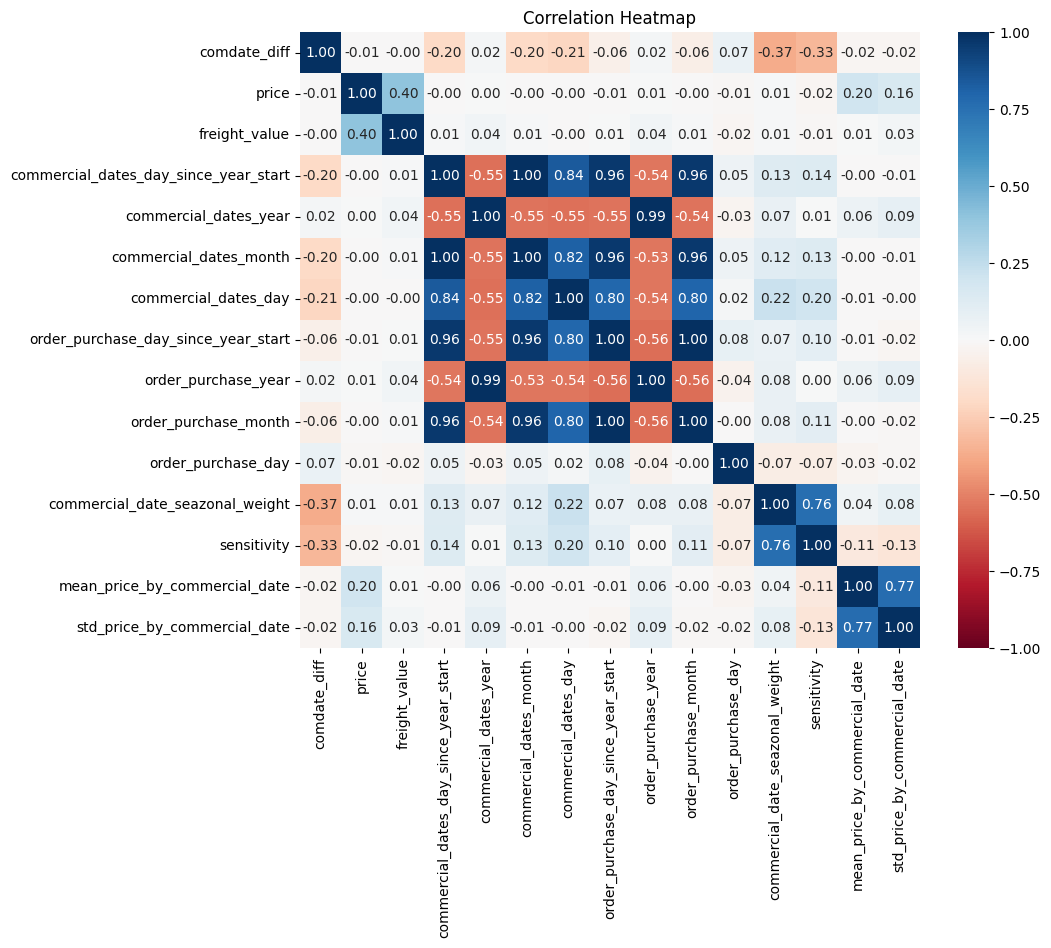

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [60]:
customer_products

,comdate_diff,commercial_date_names,price,freight_value,filtered_category,time_window_order_names,commercial_dates_day_since_year_start,commercial_dates_year,commercial_dates_month,commercial_dates_year_month,...,order_purchase_day_since_year_start,order_purchase_year,order_purchase_month,order_purchase_year_month,order_purchase_date,order_purchase_day,commercial_date_seazonal_weight,sensitivity,mean_price_by_commercial_date,std_price_by_commercial_date
0,11,Não aplica,289.00,46.48,utilidades_domesticas,Mais de duas semanas,0,2018,1,201801,...,11,2018,1,201801,20180112,12,0.000000,0.000000,92.179011,169.492277
1,-28,Não aplica,259.90,22.31,esporte_lazer,Mais de duas semanas,284,2017,10,201710,...,256,2017,9,201709,20170914,14,0.000000,0.000000,116.931149,158.173943
2,-17,Dia da Mulher,14.99,7.78,informatica_acessorios,Duas semanas,66,2018,3,201803,...,49,2018,2,201802,20180219,19,14.678600,13.587090,106.874941,134.596300
3,17,Não aplica,25.00,14.10,brinquedos,Mais de duas semanas,0,2018,1,201801,...,17,2018,1,201801,20180118,18,0.000000,0.000000,108.666584,118.364277
4,7,Reveillon,99.90,22.57,moveis_decoracao,Mais de duas semanas,0,2018,1,201801,...,7,2018,1,201801,20180108,8,3.137149,12.276657,82.903521,59.651270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87849,-8,Natal,55.00,20.88,utilidades_domesticas,Duas semanas,358,2017,12,201712,...,350,2017,12,201712,20171217,17,4.880210,6.335680,100.261696,126.620747
87850,3,Pascoa,114.90,14.16,esporte_lazer,Mais de duas semanas,90,2018,4,201804,...,93,2018,4,201804,20180404,4,10.360727,10.802792,106.242859,104.834845
87851,7,Pascoa,37.00,19.04,beleza_saude,Mais de duas semanas,90,2018,4,201804,...,97,2018,4,201804,20180408,8,10.360727,9.825480,115.585435,176.533677
87852,-21,Black Friday,689.00,22.07,relogios_presentes,Duas semanas,327,2017,11,201711,...,306,2017,11,201711,20171103,3,12.756532,6.704465,204.739577,287.452591


In [61]:
def convertToNative(x):
    return x.item()

label_encoders = {}

le_commercial_date_names = LabelEncoder()
customer_products['commercial_date_coded'] = le_commercial_date_names.fit_transform(customer_products['commercial_date_names'])
label_encoders['commercial_date_coded'] = dict(zip(list(map(convertToNative, list(le_commercial_date_names.transform(le_commercial_date_names.classes_)))), le_commercial_date_names.classes_))

le_time_window_order = LabelEncoder()
customer_products['time_window_order_coded'] = le_time_window_order.fit_transform(customer_products['time_window_order_names'])
label_encoders['time_window_order_coded'] = dict(zip(list(map(convertToNative, list(le_time_window_order.transform(le_time_window_order.classes_)))), le_time_window_order.classes_))

le_coded_filtered_category = LabelEncoder()
customer_products['filtered_category_coded'] = le_coded_filtered_category.fit_transform(customer_products['filtered_category'])
label_encoders['filtered_category_coded'] = dict(zip(list(map(convertToNative, list(le_coded_filtered_category.transform(le_coded_filtered_category.classes_)))), le_coded_filtered_category.classes_))

label_encoders

{'commercial_date_coded': {0: 'Black Friday',
  1: 'Dia da Mulher',
  2: 'Dia das Criancas',
  3: 'Dia das Maes',
  4: 'Dia dos Namorados',
  5: 'Dia dos Pais',
  6: 'Natal',
  7: 'Não aplica',
  8: 'Pascoa',
  9: 'Reveillon'},
 'time_window_order_coded': {0: 'Duas semanas',
  1: 'Mais de duas semanas',
  2: 'Uma semana'},
 'filtered_category_coded': {0: 'automotivo',
  1: 'bebes',
  2: 'beleza_saude',
  3: 'brinquedos',
  4: 'cama_mesa_banho',
  5: 'cool_stuff',
  6: 'esporte_lazer',
  7: 'ferramentas_jardim',
  8: 'informatica_acessorios',
  9: 'moveis_decoracao',
  10: 'perfumaria',
  11: 'relogios_presentes',
  12: 'telefonia',
  13: 'utilidades_domesticas'}}

In [62]:
import json
with open("./../data/clean_data/labels_encoders.json", 'w', encoding="utf-8") as fp:
    json.dump(label_encoders, fp, ensure_ascii=False)

In [63]:
customer_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87854 entries, 0 to 87853
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   comdate_diff                           87854 non-null  int64  
 1   commercial_date_names                  87854 non-null  object 
 2   price                                  87854 non-null  float64
 3   freight_value                          87854 non-null  float64
 4   filtered_category                      87854 non-null  object 
 5   time_window_order_names                87854 non-null  object 
 6   commercial_dates_day_since_year_start  87854 non-null  int64  
 7   commercial_dates_year                  87854 non-null  int64  
 8   commercial_dates_month                 87854 non-null  int64  
 9   commercial_dates_year_month            87854 non-null  object 
 10  commercial_dates_date                  87854 non-null  object 
 11  co

## Remoção de colunas que não serão utilizadas

In [64]:
customer_products.drop(columns=[ "commercial_date_names"], inplace=True)
customer_products.drop(columns=["filtered_category", "time_window_order_names"], inplace=True)
customer_products

,comdate_diff,price,freight_value,commercial_dates_day_since_year_start,commercial_dates_year,commercial_dates_month,commercial_dates_year_month,commercial_dates_date,commercial_dates_day,commercial_dates_dayofweek_name,...,order_purchase_year_month,order_purchase_date,order_purchase_day,commercial_date_seazonal_weight,sensitivity,mean_price_by_commercial_date,std_price_by_commercial_date,commercial_date_coded,time_window_order_coded,filtered_category_coded
0,11,289.00,46.48,0,2018,1,201801,20180101,1,Mon,...,201801,20180112,12,0.000000,0.000000,92.179011,169.492277,7,1,13
1,-28,259.90,22.31,284,2017,10,201710,20171012,12,Thu,...,201709,20170914,14,0.000000,0.000000,116.931149,158.173943,7,1,6
2,-17,14.99,7.78,66,2018,3,201803,20180308,8,Thu,...,201802,20180219,19,14.678600,13.587090,106.874941,134.596300,1,0,8
3,17,25.00,14.10,0,2018,1,201801,20180101,1,Mon,...,201801,20180118,18,0.000000,0.000000,108.666584,118.364277,7,1,3
4,7,99.90,22.57,0,2018,1,201801,20180101,1,Mon,...,201801,20180108,8,3.137149,12.276657,82.903521,59.651270,9,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87849,-8,55.00,20.88,358,2017,12,201712,20171225,25,Mon,...,201712,20171217,17,4.880210,6.335680,100.261696,126.620747,6,0,13
87850,3,114.90,14.16,90,2018,4,201804,20180401,1,Sun,...,201804,20180404,4,10.360727,10.802792,106.242859,104.834845,8,1,6
87851,7,37.00,19.04,90,2018,4,201804,20180401,1,Sun,...,201804,20180408,8,10.360727,9.825480,115.585435,176.533677,8,1,2
87852,-21,689.00,22.07,327,2017,11,201711,20171124,24,Fri,...,201711,20171103,3,12.756532,6.704465,204.739577,287.452591,0,0,11


## Buscando outliers

In [65]:
print(customer_products.columns)
customer_products

Index(['comdate_diff', 'price', 'freight_value',
       'commercial_dates_day_since_year_start', 'commercial_dates_year',
       'commercial_dates_month', 'commercial_dates_year_month',
       'commercial_dates_date', 'commercial_dates_day',
       'commercial_dates_dayofweek_name',
       'order_purchase_day_since_year_start', 'order_purchase_year',
       'order_purchase_month', 'order_purchase_year_month',
       'order_purchase_date', 'order_purchase_day',
       'commercial_date_seazonal_weight', 'sensitivity',
       'mean_price_by_commercial_date', 'std_price_by_commercial_date',
       'commercial_date_coded', 'time_window_order_coded',
       'filtered_category_coded'],
      dtype='object')


,comdate_diff,price,freight_value,commercial_dates_day_since_year_start,commercial_dates_year,commercial_dates_month,commercial_dates_year_month,commercial_dates_date,commercial_dates_day,commercial_dates_dayofweek_name,...,order_purchase_year_month,order_purchase_date,order_purchase_day,commercial_date_seazonal_weight,sensitivity,mean_price_by_commercial_date,std_price_by_commercial_date,commercial_date_coded,time_window_order_coded,filtered_category_coded
0,11,289.00,46.48,0,2018,1,201801,20180101,1,Mon,...,201801,20180112,12,0.000000,0.000000,92.179011,169.492277,7,1,13
1,-28,259.90,22.31,284,2017,10,201710,20171012,12,Thu,...,201709,20170914,14,0.000000,0.000000,116.931149,158.173943,7,1,6
2,-17,14.99,7.78,66,2018,3,201803,20180308,8,Thu,...,201802,20180219,19,14.678600,13.587090,106.874941,134.596300,1,0,8
3,17,25.00,14.10,0,2018,1,201801,20180101,1,Mon,...,201801,20180118,18,0.000000,0.000000,108.666584,118.364277,7,1,3
4,7,99.90,22.57,0,2018,1,201801,20180101,1,Mon,...,201801,20180108,8,3.137149,12.276657,82.903521,59.651270,9,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87849,-8,55.00,20.88,358,2017,12,201712,20171225,25,Mon,...,201712,20171217,17,4.880210,6.335680,100.261696,126.620747,6,0,13
87850,3,114.90,14.16,90,2018,4,201804,20180401,1,Sun,...,201804,20180404,4,10.360727,10.802792,106.242859,104.834845,8,1,6
87851,7,37.00,19.04,90,2018,4,201804,20180401,1,Sun,...,201804,20180408,8,10.360727,9.825480,115.585435,176.533677,8,1,2
87852,-21,689.00,22.07,327,2017,11,201711,20171124,24,Fri,...,201711,20171103,3,12.756532,6.704465,204.739577,287.452591,0,0,11


Text(0, 0.5, 'freight_value')

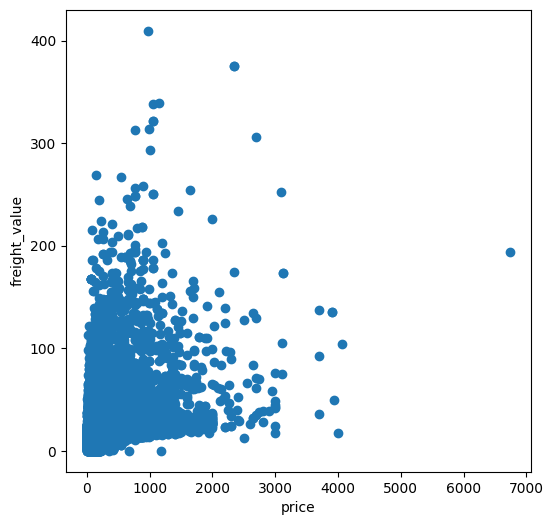

In [66]:
plt.figure(figsize=(6,6))
plt.scatter(customer_products['price'], customer_products['freight_value'])
plt.xlabel("price")
plt.ylabel("freight_value")

In [67]:
customer_products["price"].sort_values()

41576       1.2
41566       1.2
41567       1.2
41568       1.2
41569       1.2
          ...  
34026    3899.0
67160    3930.0
74131    3999.9
79714    4059.0
11999    6735.0
Name: price, Length: 87854, dtype: float64

In [68]:
print(customer_products.shape)
customer_products[customer_products["price"] > 6000].head()


(87854, 23)


,comdate_diff,price,freight_value,commercial_dates_day_since_year_start,commercial_dates_year,commercial_dates_month,commercial_dates_year_month,commercial_dates_date,commercial_dates_day,commercial_dates_dayofweek_name,...,order_purchase_year_month,order_purchase_date,order_purchase_day,commercial_date_seazonal_weight,sensitivity,mean_price_by_commercial_date,std_price_by_commercial_date,commercial_date_coded,time_window_order_coded,filtered_category_coded
11999,-24,6735.0,194.31,66,2017,3,201703,20170308,8,Wed,...,201702,20170212,12,0.0,0.0,92.179011,169.492277,7,1,13


(87853, 23)


Text(0, 0.5, 'freight_value')

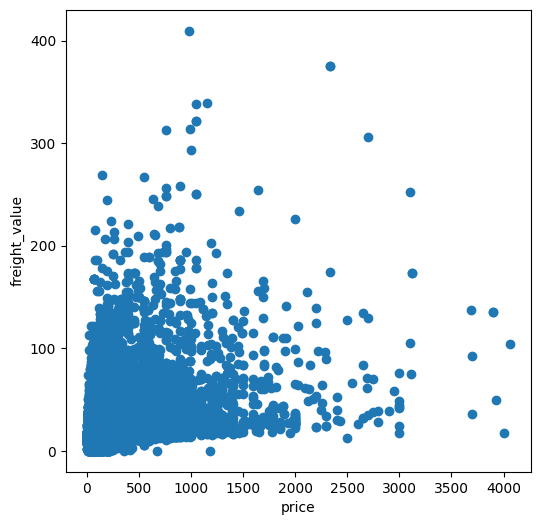

In [69]:
customer_products =  customer_products[customer_products["price"] <= 6000]
print(customer_products.shape)
plt.figure(figsize=(6,6))
plt.scatter(customer_products['price'], customer_products['freight_value'])
plt.xlabel("price")
plt.ylabel("freight_value")

## Dropando colunas 

In [70]:
customer_products.drop(columns=["commercial_dates_year_month", "commercial_dates_date", "order_purchase_year_month", "order_purchase_date", "commercial_dates_dayofweek_name"], inplace=True)

## Extração do dataset útil para clustering

In [71]:
category_seasonal_data = customer_products.copy()
category_seasonal_data

,comdate_diff,price,freight_value,commercial_dates_day_since_year_start,commercial_dates_year,commercial_dates_month,commercial_dates_day,order_purchase_day_since_year_start,order_purchase_year,order_purchase_month,order_purchase_day,commercial_date_seazonal_weight,sensitivity,mean_price_by_commercial_date,std_price_by_commercial_date,commercial_date_coded,time_window_order_coded,filtered_category_coded
0,11,289.00,46.48,0,2018,1,1,11,2018,1,12,0.000000,0.000000,92.179011,169.492277,7,1,13
1,-28,259.90,22.31,284,2017,10,12,256,2017,9,14,0.000000,0.000000,116.931149,158.173943,7,1,6
2,-17,14.99,7.78,66,2018,3,8,49,2018,2,19,14.678600,13.587090,106.874941,134.596300,1,0,8
3,17,25.00,14.10,0,2018,1,1,17,2018,1,18,0.000000,0.000000,108.666584,118.364277,7,1,3
4,7,99.90,22.57,0,2018,1,1,7,2018,1,8,3.137149,12.276657,82.903521,59.651270,9,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87849,-8,55.00,20.88,358,2017,12,25,350,2017,12,17,4.880210,6.335680,100.261696,126.620747,6,0,13
87850,3,114.90,14.16,90,2018,4,1,93,2018,4,4,10.360727,10.802792,106.242859,104.834845,8,1,6
87851,7,37.00,19.04,90,2018,4,1,97,2018,4,8,10.360727,9.825480,115.585435,176.533677,8,1,2
87852,-21,689.00,22.07,327,2017,11,24,306,2017,11,3,12.756532,6.704465,204.739577,287.452591,0,0,11


In [72]:
category_seasonal_data = customer_products.copy()
category_seasonal_data.to_parquet('./../data/clean_data/category_seasonal_data.parquet')
category_seasonal_data

,comdate_diff,price,freight_value,commercial_dates_day_since_year_start,commercial_dates_year,commercial_dates_month,commercial_dates_day,order_purchase_day_since_year_start,order_purchase_year,order_purchase_month,order_purchase_day,commercial_date_seazonal_weight,sensitivity,mean_price_by_commercial_date,std_price_by_commercial_date,commercial_date_coded,time_window_order_coded,filtered_category_coded
0,11,289.00,46.48,0,2018,1,1,11,2018,1,12,0.000000,0.000000,92.179011,169.492277,7,1,13
1,-28,259.90,22.31,284,2017,10,12,256,2017,9,14,0.000000,0.000000,116.931149,158.173943,7,1,6
2,-17,14.99,7.78,66,2018,3,8,49,2018,2,19,14.678600,13.587090,106.874941,134.596300,1,0,8
3,17,25.00,14.10,0,2018,1,1,17,2018,1,18,0.000000,0.000000,108.666584,118.364277,7,1,3
4,7,99.90,22.57,0,2018,1,1,7,2018,1,8,3.137149,12.276657,82.903521,59.651270,9,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87849,-8,55.00,20.88,358,2017,12,25,350,2017,12,17,4.880210,6.335680,100.261696,126.620747,6,0,13
87850,3,114.90,14.16,90,2018,4,1,93,2018,4,4,10.360727,10.802792,106.242859,104.834845,8,1,6
87851,7,37.00,19.04,90,2018,4,1,97,2018,4,8,10.360727,9.825480,115.585435,176.533677,8,1,2
87852,-21,689.00,22.07,327,2017,11,24,306,2017,11,3,12.756532,6.704465,204.739577,287.452591,0,0,11
